# Applying BERT Multilingual Classifier to Predict Account Suspension 

Guidance from: https://github.com/kacossio/TeamPython/blob/master/Bert%20Multilingual%20Embedding.ipynb

## 1. Load Packages

In [38]:
########## Load Packages
import warnings
warnings.simplefilter("ignore")

import importlib
import pandas as pd
import numpy as np
import re
from io import StringIO
import itertools
import os 
import time
import datetime

from io import StringIO # python3; python2: BytesIO 
import boto3

import emoji
import random 
import math

from sklearn import preprocessing

from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from translate import Translator
import spacy
import langid
import keras_bert
import tensorflow as tf
import time
import datetime as dt
import pytz

from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import Lasso, LogisticRegression

import bert
from bert import tokenization

import pickle

import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow import keras
import random as rn
from keras.models import Model,save_model, load_model, Sequential
from keras.layers import Flatten,AveragePooling1D,Dropout,Dense,Input, BatchNormalization
from tensorflow.keras.optimizers import Adam
import keras.backend as K
import IPython
from sklearn.metrics import classification_report,confusion_matrix
from sklearn import preprocessing
from keras.utils import to_categorical
import pydot
import graphviz
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
import kerastuner as kt
from kerastuner import HyperModel
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

## 2. Set parameters

In [24]:
# Set Parameters 
########## Set Parameters

# Indicate how many rows to skip before columns
# Note: Python uses zero-based indexing, so skiprow=0 begins at the first row of file,
# while skiprow=1 begins at the second row.
skiprow=0

# Indicate name of column that contains text data for analysis
text_column = "text"

filepath = "data/"

import_bucket = "joe-exotic-2020"

embedding_bucket = "modeling/embeddings"

key = 'full_clean' # already created on S3
csv_buffer = StringIO()
s3_resource = boto3.resource('s3')
s3 = boto3.client('s3')

results_bucket = 'full_clean' # already created on S3

## 3. Load in Data from S3

In [25]:
def import_data(filelist):
    '''Read in data from excel files into Pandas dataframe.
    Inputs: Filelist 
    Outputs: Pandas dataframe containing imported data
    '''

    # Read in single file
    object_key = filelist[0].split('/', 1)[1]
    csv_obj = s3.get_object(Bucket=import_bucket, Key=object_key)
    body = csv_obj['Body']
    csv_string = body.read().decode('utf-8')
    df = pd.read_csv(StringIO(csv_string), error_bad_lines=False)
    
    return df

### Load in data from S3

In [26]:
#### Load in data from S3

# Import Train and Measure Balance
# Import Flattened Data
filelist = [os.path.join(obj.bucket_name, obj.key) 
    for obj in s3_resource.Bucket(name=import_bucket).objects.all() 
    if re.findall("train_updated",obj.key)]

df_train = import_data(filelist)

df_train['suspended'] = pd.to_numeric(df_train['suspended'], errors='coerce')
df_train = df_train[df_train['suspended'].notna()]

# Import Test and Measure Balance

filelist = [os.path.join(obj.bucket_name, obj.key) 
    for obj in s3_resource.Bucket(name=import_bucket).objects.all() 
    if re.findall("test_updated",obj.key)]

df_test = import_data(filelist)

df_test['suspended'] = pd.to_numeric(df_test['suspended'], errors='coerce')
df_test = df_test[df_test['suspended'].notna()]

# Import Validation and Measure Balance
# Import Flattened Data
filelist = [os.path.join(obj.bucket_name, obj.key) 
    for obj in s3_resource.Bucket(name=import_bucket).objects.all() 
    if re.findall("valid_updated",obj.key)]

df_valid = import_data(filelist)

df_valid['suspended'] = pd.to_numeric(df_valid['suspended'], errors='coerce')
df_valid = df_valid[df_valid['suspended'].notna()]



### Supplementary Pre-Processing

#### Ensure that Target Variable is Numeric 

In [27]:
df_train['suspended'] = df_train['suspended'].astype(int)
df_valid['suspended'] = df_valid['suspended'].astype(int)
df_test['suspended'] = df_test['suspended'].astype(int)

#### Remove Duplicates 

In [28]:
df_train = df_train.drop_duplicates(subset=['id', 'created_at', 'text'])
df_valid = df_valid.drop_duplicates(subset=['id', 'created_at', 'text'])
df_test = df_test.drop_duplicates(subset=['id', 'created_at', 'text'])

#### Ensure binary possibly_sensitive vars

In [29]:
df_train['possibly_sensitive'][df_train['possibly_sensitive'].apply(lambda x: isinstance(x, str))] =np.nan
df_valid['possibly_sensitive'][df_valid['possibly_sensitive'].apply(lambda x: isinstance(x, str))] =np.nan
df_test['possibly_sensitive'][df_test['possibly_sensitive'].apply(lambda x: isinstance(x, str))] =np.nan

## 4. Extract Embeddings

### Prep for Tensor 

#### Convert Dates to Unix Epoch Time

In [30]:
### Function to convert dates into float (Unix Epoch Times )
def convert_dates_float(df):
    '''
    Convert key input data variables to numeric format for tensors. Uses unix epoch time in seconds. 
    '''
    # created_at (tweet)
    df['created_at'] = pd.to_datetime(df['created_at'], format='%Y-%m-%d %H:%M:%S.%f')
    my_datetime = dt.datetime(1970,1,1) 
    good_dt = pytz.timezone('UTC').localize(my_datetime)
    df['created_at'] = (df['created_at'] - good_dt).dt.total_seconds()

    # User.created_at (account)
    df['user.created_at'] = pd.to_datetime(df['user.created_at'], format='%Y-%m-%d %H:%M:%S.%f')
    my_datetime = dt.datetime(1970,1,1) 
    good_dt = pytz.timezone('UTC').localize(my_datetime)
    df['user.created_at'] = (df['user.created_at'] - good_dt).dt.total_seconds()
    
    return df

#### Convert binary and categorical variables to one-hot encoded (not sure this is best or not)

Options 

- Integer Encoding: Where each unique label is mapped to an integer.
- One Hot Encoding: Where each label is mapped to a binary vector.
- Learned Embedding: Where a distributed representation of the categories is learned.

We use one hot encoding below. 

#### We use get_dummies below instead of one_hot_encoder as get dummies knows how to deal with missingness. 

In [31]:
### One Hote Encoding (Unix Epoch Times )
def one_hot(df_train, df_valid, df_test): 
    '''
    One hot encoding requires the full dataset in order to ensure that there end up the same amount of columns for test, validation and train.
    We therefore combine train, valid, and test, fill nas with 0 where necessary, and one hot encode categorical vars. 
    '''
    df_train['split'] = "train"
    df_valid['split'] = "valid"
    df_test['split'] = "test"
    df = pd.concat([df_train, df_test, df_valid], ignore_index=True, sort=False)
    df = convert_dates_float(df)
    # Extra layer of Processing 
    df = df[df['retweet_count'] != "False"] 
    df['quoted_status.user.followers_count'] = df['quoted_status.user.followers_count'].fillna(0) 
    df['quoted_status.user.friends_count'] = df['quoted_status.user.friends_count'].fillna(0) 
    df['retweeted_status.user.followers_count'] = df['retweeted_status.user.followers_count'].fillna(0) 
    df['retweeted_status.user.friends_count'] = df['retweeted_status.user.friends_count'].fillna(0) 
    # One-hot
    df = df.drop(["user.protected.1", "user.protected.2", "user.protected.3"], axis=1)
    df = pd.get_dummies(df, columns=["source", "lang", "possibly_sensitive", "withheld_in_countries", "place.country", 
                                         "user.geo_enabled", "user.lang", "user.verified", "user.has_extended_profile",
                                        "user.lang", "user.protected", "user.time_zone", "user.verified", "user.default_profile",
                                        "is_quote_status"])
    return df
# Tp get rid of: Text, user.protected.1, user.protected.2, user.protected.3, 
# To concat (or get rid of): user.description, user.location, user.name, user.screen_name
# to potentially take out entirely - user.id (This would explain everything)


#### Split one-hot encoded df back apart into train, valid, and test

In [32]:
df = one_hot(df_train, df_valid, df_test)
df_train_f = df[df['split'] == "train"]
df_valid_f = df[df['split'] == "valid"]
df_test_f = df[df['split'] == "test"]


#### Remove other text fields (may concatanate with tweets in future iterations)

In [33]:
df_train = df_train_f.drop(['user.description', "user.location", "user.name", "user.screen_name", "split"], axis=1)
df_valid = df_valid_f.drop(['user.description', "user.location", "user.name", "user.screen_name", "split"], axis=1)
df_test = df_test_f.drop(['user.description', "user.location", "user.name", "user.screen_name", "split"], axis=1)

In [34]:
df_train.head()

,id,created_at,text,retweet_count,favorite_count,quoted_status_id,user.id,user.created_at,user.favourites_count,user.followers_count,...,user.geo_enabled_False,user.geo_enabled_True,user.verified_False,user.has_extended_profile_False,user.has_extended_profile_True,user.protected_False,user.verified_False,user.default_profile_True,is_quote_status_False,is_quote_status_True
1,1.304799e+18,1.599923e+09,containcontrast you are as worse as nazi germ...,0.0,1.0,0.0,1.278120e+18,1.593563e+09,25355.0,377.0,...,1,0,1,0,1,1,1,1,1,0
2,1.304796e+18,1.599923e+09,RT bcelyj nevernever maryann CCP CCCP CCCP,1.0,0.0,0.0,1.278120e+18,1.593563e+09,25355.0,377.0,...,1,0,1,0,1,1,1,1,1,0
3,1.304796e+18,1.599923e+09,RT maryann CCP CCP https co EAFQGqFQ,802.0,0.0,0.0,1.278120e+18,1.593563e+09,25355.0,377.0,...,1,0,1,0,1,1,1,1,1,0
4,1.304795e+18,1.599922e+09,https co oBzs zO https co Si btzc U,0.0,15.0,1.0,1.278120e+18,1.593563e+09,25355.0,377.0,...,1,0,1,0,1,1,1,1,0,1
5,1.304794e+18,1.599922e+09,https co oBzs zO Z,0.0,10.0,1.0,1.278120e+18,1.593563e+09,25355.0,377.0,...,1,0,1,0,1,1,1,1,0,1


### Define embeddings functions

In [35]:
#get tweets from dataframe
def get_tweets_list(df):
    '''
    Convert panda series of tweets into list of tweets and output id_list for tweets. 
    '''
    id_list = []
    all_tweets = []
    for num in range(len(df)):
        all_tweets.append(df.iloc[num]['text'])
        id_list.append(df.iloc[num]['id'])
    return all_tweets,id_list

#input list of tweets with structure as [[tweet, screen_name],[tweet, screen_name],[tweet, screen_name],...]
def get_bert_embeddings(tweet_list):
    '''
    Extracy embeddings using tf hub supplied model path and your tweet list.
    '''
    model_path = "multi_cased_L-12_H-768_A-12"
    embeddings = keras_bert.extract_embeddings(model_path, tweet_list)
    print('embeddings complete')
    return(embeddings)

#mean pool the embeddings to return 768 embeddings per sentence
def avg_pooling(embed_array):
    '''
    Mean pool the embeddings to return 768 embeddings per sentence. 
    '''
    embeddings_pooled = []
    for sentence in embed_array:
        sentence = np.expand_dims((sentence),axis = 0)
        sentence = tf.keras.layers.GlobalAveragePooling1D()(sentence)
        embeddings_pooled.append(np.squeeze(sentence))
    return(embeddings_pooled)

### Extract Embeddings for Multilingual BERT

This is the computationally intense part needing the GPU

#### Train

In [36]:
len(df_train)

107374

In [37]:
#extracted first 10 tweets and check the time.
start= time.time()
list_of_tweets_train, id_tweet_train = get_tweets_list(df_train[:300])
bert_embeddings_train = get_bert_embeddings(list_of_tweets_train)
bert_pooled_train = avg_pooling(bert_embeddings_train)
print(time.time() - start)

AttributeError: module 'tensorflow.python.framework.ops' has no attribute '_TensorLike'

#### Valid

In [199]:
#extracted first 10 tweets and check the time.
start= time.time()
list_of_tweets_valid, id_tweet_valid = get_tweets_list(df_valid[:300])
bert_embeddings_valid = get_bert_embeddings(list_of_tweets_valid)
bert_pooled_valid = avg_pooling(bert_embeddings_valid)
print(time.time() - start)

embeddings complete
255.11779689788818


#### Test

In [200]:
#extracted first 10 tweets and check the time.
start= time.time()
list_of_tweets_test, id_tweet_test = get_tweets_list(df_test[:300])
bert_embeddings_test = get_bert_embeddings(list_of_tweets_test)
bert_pooled_test = avg_pooling(bert_embeddings_test)
print(time.time() - start)

embeddings complete
250.45892524719238


### Combine the text of each screen name in order to classify per screen name. 

An alternative that we'll have to try to incorporate is to fit in the time series element. 

#### Train

In [288]:
#bert embedding
bert_embeddings_df_train = pd.DataFrame(list(zip(id_tweet_train, bert_pooled_train)),columns=['id', 'Bert_embeddings'])
bert_embeddings_df_train = pd.concat([bert_embeddings_df_train['id'], bert_embeddings_df_train['Bert_embeddings'].apply(pd.Series)], axis = 1)
bert_embeddings_df_train = pd.merge(df_train[:300].drop(['text'], axis=1), bert_embeddings_df_train, left_on = ["id"], right_on = ["id"])
.head()

,id,created_at,retweet_count,favorite_count,quoted_status_id,user.id,user.created_at,user.favourites_count,user.followers_count,user.friends_count,user.listed_count,user.statuses_count,quoted_status.user.followers_count,quoted_status.user.friends_count,retweeted_status.user.followers_count,retweeted_status.user.friends_count,user_age,tweets_per_day,since_last_tweet_mins,since_last_tweet_mins_min,since_last_tweet_mins_max,since_last_tweet_mins_mean,avg_tweets_per_hr,avg_tweets_per_day,no_hashtags,no_mentions,no_urls,tw_len,followers_per_followees,containsURL,user.urls_per_tweet,no_hashtags_per_tweet,no_mentions_per_tweet,no_urls_per_tweet,user.followers_countdailychange,user.friends_countdailychange,user.friend_rate,user.followers_rate,user.has_url,user.has_location,user.screen_name.digit_length,user.screen_name.length,is_reply,suspended,source_ Round Year Fun!,source_ Round Year Fum,source_ Round Year Fum,source_ Round Year Fum,source_ Round Year Fum,source_ 「モンストからツイート」,source_Affinitweet.com,source_BIGO LIVE,source_Blog2Social APP,source_CallApp,source_Etsy,source_Instagram,source_Joinfsocial,source_Mobile Web (M2),source_Nintendo Switch Share,source_Paper.li,source_Peing,source_SocialPilot.co,source_TeamSight Publisher,source_TweetDeck,source_Twibbon,source_Twitter Web App,source_Twitter Web Client,source_Twitter for Android,source_Twitter for Mac,source_Twitter for iPad,source_Twitter for iPhone,source_WShare,source_WordPress.com,source_漫威超級戰爭（MARVEL Super War）,lang_False,lang_am,lang_ar,lang_bg,lang_bn,lang_bo,lang_ca,lang_ckb,lang_cs,lang_cy,lang_da,lang_de,lang_el,lang_en,lang_es,lang_et,lang_eu,lang_fa,lang_fi,lang_fr,lang_gu,lang_hi,lang_ht,lang_hu,lang_hy,lang_in,lang_is,lang_it,lang_iw,lang_ja,lang_km,lang_ko,lang_lt,lang_lv,lang_ml,lang_mr,lang_ne,lang_nl,lang_no,lang_pl,lang_ps,lang_pt,lang_ro,lang_ru,lang_sd,lang_si,lang_sl,lang_sr,lang_sv,lang_ta,lang_th,lang_tl,lang_tr,lang_uk,lang_und,lang_ur,lang_vi,lang_zh,possibly_sensitive_False,possibly_sensitive_True,withheld_in_countries_['IN'],withheld_in_countries_['TR'],place.country_Finland,place.country_Hong Kong,place.country_India,place.country_Indonesia,place.country_Italy,place.country_Mongolia,place.country_Pakistan,place.country_People's Republic of China,place.country_Portugal,place.country_Republic of Korea,place.country_Russia,place.country_Singapore,place.country_Sri Lanka,place.country_United Arab Emirates,place.country_United States,user.geo_enabled_False,user.geo_enabled_True,user.verified_False,user.has_extended_profile_False,user.has_extended_profile_True,user.protected_False,user.verified_False,user.default_profile_True,is_quote_status_False,is_quote_status_True,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,35

In [289]:
len(bert_embeddings_df_train)

300

In [291]:
bert_embeddings_df_train_accounts = bert_embeddings_df_train[['user.id', 'suspended']].groupby('user.id').mean()
bert_embeddings_df_train_accounts.suspended.value_counts() 

array([1])

#### Valid

In [292]:
#bert embedding
bert_embeddings_df_valid = pd.DataFrame(list(zip(id_tweet_valid, bert_pooled_valid)),columns=['id', 'Bert_embeddings'])
bert_embeddings_df_valid = pd.concat([bert_embeddings_df_valid['id'], bert_embeddings_df_valid['Bert_embeddings'].apply(pd.Series)], axis = 1)
bert_embeddings_df_valid = pd.merge(df_valid[:300].drop(['text'], axis=1), bert_embeddings_df_valid, left_on = ["id"], right_on = ["id"])
bert_embeddings_df_valid.head()

,id,created_at,retweet_count,favorite_count,quoted_status_id,user.id,user.created_at,user.favourites_count,user.followers_count,user.friends_count,user.listed_count,user.statuses_count,quoted_status.user.followers_count,quoted_status.user.friends_count,retweeted_status.user.followers_count,retweeted_status.user.friends_count,user_age,tweets_per_day,since_last_tweet_mins,since_last_tweet_mins_min,since_last_tweet_mins_max,since_last_tweet_mins_mean,avg_tweets_per_hr,avg_tweets_per_day,no_hashtags,no_mentions,no_urls,tw_len,followers_per_followees,containsURL,user.urls_per_tweet,no_hashtags_per_tweet,no_mentions_per_tweet,no_urls_per_tweet,user.followers_countdailychange,user.friends_countdailychange,user.friend_rate,user.followers_rate,user.has_url,user.has_location,user.screen_name.digit_length,user.screen_name.length,is_reply,suspended,source_ Round Year Fun!,source_ Round Year Fum,source_ Round Year Fum,source_ Round Year Fum,source_ Round Year Fum,source_ 「モンストからツイート」,source_Affinitweet.com,source_BIGO LIVE,source_Blog2Social APP,source_CallApp,source_Etsy,source_Instagram,source_Joinfsocial,source_Mobile Web (M2),source_Nintendo Switch Share,source_Paper.li,source_Peing,source_SocialPilot.co,source_TeamSight Publisher,source_TweetDeck,source_Twibbon,source_Twitter Web App,source_Twitter Web Client,source_Twitter for Android,source_Twitter for Mac,source_Twitter for iPad,source_Twitter for iPhone,source_WShare,source_WordPress.com,source_漫威超級戰爭（MARVEL Super War）,lang_False,lang_am,lang_ar,lang_bg,lang_bn,lang_bo,lang_ca,lang_ckb,lang_cs,lang_cy,lang_da,lang_de,lang_el,lang_en,lang_es,lang_et,lang_eu,lang_fa,lang_fi,lang_fr,lang_gu,lang_hi,lang_ht,lang_hu,lang_hy,lang_in,lang_is,lang_it,lang_iw,lang_ja,lang_km,lang_ko,lang_lt,lang_lv,lang_ml,lang_mr,lang_ne,lang_nl,lang_no,lang_pl,lang_ps,lang_pt,lang_ro,lang_ru,lang_sd,lang_si,lang_sl,lang_sr,lang_sv,lang_ta,lang_th,lang_tl,lang_tr,lang_uk,lang_und,lang_ur,lang_vi,lang_zh,possibly_sensitive_False,possibly_sensitive_True,withheld_in_countries_['IN'],withheld_in_countries_['TR'],place.country_Finland,place.country_Hong Kong,place.country_India,place.country_Indonesia,place.country_Italy,place.country_Mongolia,place.country_Pakistan,place.country_People's Republic of China,place.country_Portugal,place.country_Republic of Korea,place.country_Russia,place.country_Singapore,place.country_Sri Lanka,place.country_United Arab Emirates,place.country_United States,user.geo_enabled_False,user.geo_enabled_True,user.verified_False,user.has_extended_profile_False,user.has_extended_profile_True,user.protected_False,user.verified_False,user.default_profile_True,is_quote_status_False,is_quote_status_True,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,35

In [293]:
len(bert_embeddings_df_valid)

300

In [294]:
bert_embeddings_df_valid_accounts = bert_embeddings_df_valid[['user.id', 'suspended']].groupby('user.id').mean()
bert_embeddings_df_valid_accounts.suspended.value_counts() 

array([0, 1])

### Test

In [295]:
#bert embedding
bert_embeddings_df_test = pd.DataFrame(list(zip(id_tweet_test, bert_pooled_test)),columns=['id', 'Bert_embeddings'])
bert_embeddings_df_test = pd.concat([bert_embeddings_df_test['id'], bert_embeddings_df_test['Bert_embeddings'].apply(pd.Series)], axis = 1)
bert_embeddings_df_test = pd.merge(df_test[:300].drop(['text'], axis=1), bert_embeddings_df_test, left_on = ["id"], right_on = ["id"])
bert_embeddings_df_test.head()

,id,created_at,retweet_count,favorite_count,quoted_status_id,user.id,user.created_at,user.favourites_count,user.followers_count,user.friends_count,user.listed_count,user.statuses_count,quoted_status.user.followers_count,quoted_status.user.friends_count,retweeted_status.user.followers_count,retweeted_status.user.friends_count,user_age,tweets_per_day,since_last_tweet_mins,since_last_tweet_mins_min,since_last_tweet_mins_max,since_last_tweet_mins_mean,avg_tweets_per_hr,avg_tweets_per_day,no_hashtags,no_mentions,no_urls,tw_len,followers_per_followees,containsURL,user.urls_per_tweet,no_hashtags_per_tweet,no_mentions_per_tweet,no_urls_per_tweet,user.followers_countdailychange,user.friends_countdailychange,user.friend_rate,user.followers_rate,user.has_url,user.has_location,user.screen_name.digit_length,user.screen_name.length,is_reply,suspended,source_ Round Year Fun!,source_ Round Year Fum,source_ Round Year Fum,source_ Round Year Fum,source_ Round Year Fum,source_ 「モンストからツイート」,source_Affinitweet.com,source_BIGO LIVE,source_Blog2Social APP,source_CallApp,source_Etsy,source_Instagram,source_Joinfsocial,source_Mobile Web (M2),source_Nintendo Switch Share,source_Paper.li,source_Peing,source_SocialPilot.co,source_TeamSight Publisher,source_TweetDeck,source_Twibbon,source_Twitter Web App,source_Twitter Web Client,source_Twitter for Android,source_Twitter for Mac,source_Twitter for iPad,source_Twitter for iPhone,source_WShare,source_WordPress.com,source_漫威超級戰爭（MARVEL Super War）,lang_False,lang_am,lang_ar,lang_bg,lang_bn,lang_bo,lang_ca,lang_ckb,lang_cs,lang_cy,lang_da,lang_de,lang_el,lang_en,lang_es,lang_et,lang_eu,lang_fa,lang_fi,lang_fr,lang_gu,lang_hi,lang_ht,lang_hu,lang_hy,lang_in,lang_is,lang_it,lang_iw,lang_ja,lang_km,lang_ko,lang_lt,lang_lv,lang_ml,lang_mr,lang_ne,lang_nl,lang_no,lang_pl,lang_ps,lang_pt,lang_ro,lang_ru,lang_sd,lang_si,lang_sl,lang_sr,lang_sv,lang_ta,lang_th,lang_tl,lang_tr,lang_uk,lang_und,lang_ur,lang_vi,lang_zh,possibly_sensitive_False,possibly_sensitive_True,withheld_in_countries_['IN'],withheld_in_countries_['TR'],place.country_Finland,place.country_Hong Kong,place.country_India,place.country_Indonesia,place.country_Italy,place.country_Mongolia,place.country_Pakistan,place.country_People's Republic of China,place.country_Portugal,place.country_Republic of Korea,place.country_Russia,place.country_Singapore,place.country_Sri Lanka,place.country_United Arab Emirates,place.country_United States,user.geo_enabled_False,user.geo_enabled_True,user.verified_False,user.has_extended_profile_False,user.has_extended_profile_True,user.protected_False,user.verified_False,user.default_profile_True,is_quote_status_False,is_quote_status_True,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,35

In [296]:
len(bert_embeddings_df_test)

300

In [297]:
bert_embeddings_df_test_accounts = bert_embeddings_df_test[['user.id', 'suspended']].groupby('user.id').mean()
bert_embeddings_df_test_accounts.suspended.value_counts() 

array([0, 1])

### Save Multilngual Embeddings 

In [299]:
bert_embeddings_df_train.to_csv('s3://joe-exotic-2020/modeling/embeddings/ml_train_embeddings_df_sub.csv', index=False, encoding = "utf_8_sig")

In [319]:
bert_embeddings_df_valid.to_csv('s3://joe-exotic-2020/modeling/embeddings/ml_valid_embeddings_df_sub.csv', index=False, encoding = "utf_8_sig")

In [320]:
bert_embeddings_df_test.to_csv('s3://joe-exotic-2020/modeling/embeddings/ml_test_embeddings_df_sub.csv', index=False, encoding = "utf_8_sig")

### LABSE: Extracting the new BERT embeddings that learn across languages

https://towardsdatascience.com/labse-language-agnostic-bert-sentence-embedding-by-google-ai-531f677d775f

In [134]:
# !pip install bert-for-tf2

vocab_file = labse_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = labse_layer.resolved_object.do_lower_case.numpy()
tokenizer = bert.tokenization.FullTokenizer(vocab_file, do_lower_case)

def create_input(input_strings, tokenizer, max_seq_length):
    '''
    Set up function to create inputs needed for word embeddings extraction. 
    '''
    input_ids_all, input_mask_all, segment_ids_all = [], [], []
    for input_string in input_strings:
        # Tokenize input.
        input_tokens = ["[CLS]"] + tokenizer.tokenize(input_string) + ["[SEP]"]
        input_ids = tokenizer.convert_tokens_to_ids(input_tokens)
        sequence_length = min(len(input_ids), max_seq_length)

    # Padding or truncation.
    if len(input_ids) >= max_seq_length:
        input_ids = input_ids[:max_seq_length]
    else:
        input_ids = input_ids + [0] * (max_seq_length - len(input_ids))

    input_mask = [1] * sequence_length + [0] * (max_seq_length - sequence_length)

    input_ids_all.append(input_ids)
    input_mask_all.append(input_mask)
    segment_ids_all.append([0] * max_seq_length)

    return np.array(input_ids_all), np.array(input_mask_all), np.array(segment_ids_all)

def encode(input_text):
    '''
    Function to extract word embedding for each sentence. 
    '''
    input_ids, input_mask, segment_ids = create_input(
        input_text, tokenizer, max_seq_length)
    return labse_model([input_ids, input_mask, segment_ids])


#input list of tweets with structure as [[tweet, screen_name],[tweet, screen_name],[tweet, screen_name],...]
embedded_tweets = list()
def get_bert_embeddings_labse(tweet_list):
    for sent in tweet_list:
        a = np.array(encode(sent))
        embedded_tweets.append(a[0])
    return embedded_tweets

# https://tfhub.dev/google/LaBSE/1

#### Train

In [135]:
#extracted first 10 tweets and check the time.
start= time.time()
list_of_tweets_train, id_tweet_train = get_tweets_list(df_train[:300])
bert_pooled_train_labse = get_bert_embeddings_labse(list_of_tweets_train)
print(time.time() - start)

27.818172216415405


#### Valid

In [138]:
#extracted first 10 tweets and check the time.
start= time.time()
list_of_tweets_valid, id_tweet_valid = get_tweets_list(df_valid[:300])
bert_pooled_valid_labse = get_bert_embeddings_labse(list_of_tweets_valid)
print(time.time() - start)

28.849069833755493


#### Test

In [139]:
#extracted first 10 tweets and check the time.
start= time.time()
list_of_tweets_test, id_tweet_test = get_tweets_list(df_test[:300])
bert_pooled_test_labse = get_bert_embeddings_labse(list_of_tweets_test)
print(time.time() - start)

28.602717876434326


#### Combine the text of each screen name in order to classify per screen name. An alternative that we'll have to try to incorporate is to fit in the time series element. 

#### Train

In [343]:
#bert embedding
bert_embeddings_df_train_labse = pd.DataFrame(list(zip(id_tweet_train, bert_pooled_train_labse)),columns=['id', 'Bert_embeddings'])
bert_embeddings_df_train_labse = pd.concat([bert_embeddings_df_train_labse['id'], bert_embeddings_df_train_labse['Bert_embeddings'].apply(pd.Series)], axis = 1)
bert_embeddings_df_train_labse = pd.merge(df_train[:300].drop(['text'], axis=1), bert_embeddings_df_train_labse, left_on = ["id"], right_on = ["id"])
bert_embeddings_df_train_labse.head()

,id,created_at,retweet_count,favorite_count,quoted_status_id,user.id,user.created_at,user.favourites_count,user.followers_count,user.friends_count,user.listed_count,user.statuses_count,quoted_status.user.followers_count,quoted_status.user.friends_count,retweeted_status.user.followers_count,retweeted_status.user.friends_count,user_age,tweets_per_day,since_last_tweet_mins,since_last_tweet_mins_min,since_last_tweet_mins_max,since_last_tweet_mins_mean,avg_tweets_per_hr,avg_tweets_per_day,no_hashtags,no_mentions,no_urls,tw_len,followers_per_followees,containsURL,user.urls_per_tweet,no_hashtags_per_tweet,no_mentions_per_tweet,no_urls_per_tweet,user.followers_countdailychange,user.friends_countdailychange,user.friend_rate,user.followers_rate,user.has_url,user.has_location,user.screen_name.digit_length,user.screen_name.length,is_reply,suspended,source_ Round Year Fun!,source_ Round Year Fum,source_ Round Year Fum,source_ Round Year Fum,source_ Round Year Fum,source_ 「モンストからツイート」,source_Affinitweet.com,source_BIGO LIVE,source_Blog2Social APP,source_CallApp,source_Etsy,source_Instagram,source_Joinfsocial,source_Mobile Web (M2),source_Nintendo Switch Share,source_Paper.li,source_Peing,source_SocialPilot.co,source_TeamSight Publisher,source_TweetDeck,source_Twibbon,source_Twitter Web App,source_Twitter Web Client,source_Twitter for Android,source_Twitter for Mac,source_Twitter for iPad,source_Twitter for iPhone,source_WShare,source_WordPress.com,source_漫威超級戰爭（MARVEL Super War）,lang_False,lang_am,lang_ar,lang_bg,lang_bn,lang_bo,lang_ca,lang_ckb,lang_cs,lang_cy,lang_da,lang_de,lang_el,lang_en,lang_es,lang_et,lang_eu,lang_fa,lang_fi,lang_fr,lang_gu,lang_hi,lang_ht,lang_hu,lang_hy,lang_in,lang_is,lang_it,lang_iw,lang_ja,lang_km,lang_ko,lang_lt,lang_lv,lang_ml,lang_mr,lang_ne,lang_nl,lang_no,lang_pl,lang_ps,lang_pt,lang_ro,lang_ru,lang_sd,lang_si,lang_sl,lang_sr,lang_sv,lang_ta,lang_th,lang_tl,lang_tr,lang_uk,lang_und,lang_ur,lang_vi,lang_zh,possibly_sensitive_False,possibly_sensitive_True,withheld_in_countries_['IN'],withheld_in_countries_['TR'],place.country_Finland,place.country_Hong Kong,place.country_India,place.country_Indonesia,place.country_Italy,place.country_Mongolia,place.country_Pakistan,place.country_People's Republic of China,place.country_Portugal,place.country_Republic of Korea,place.country_Russia,place.country_Singapore,place.country_Sri Lanka,place.country_United Arab Emirates,place.country_United States,user.geo_enabled_False,user.geo_enabled_True,user.verified_False,user.has_extended_profile_False,user.has_extended_profile_True,user.protected_False,user.verified_False,user.default_profile_True,is_quote_status_False,is_quote_status_True,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,35

In [344]:
len(bert_embeddings_df_train_labse)

300

In [345]:
bert_embeddings_df_train_labse['suspended'].unique()

array([1])

#### Valid

In [346]:
#bert embedding
bert_embeddings_df_valid_labse = pd.DataFrame(list(zip(id_tweet_valid, bert_pooled_valid_labse)),columns=['id', 'Bert_embeddings'])
bert_embeddings_df_valid_labse = pd.concat([bert_embeddings_df_valid_labse['id'], bert_embeddings_df_valid_labse['Bert_embeddings'].apply(pd.Series)], axis = 1)
bert_embeddings_df_valid_labse = pd.merge(df_valid[:300].drop(['text'], axis=1), bert_embeddings_df_valid_labse, left_on = ["id"], right_on = ["id"])
bert_embeddings_df_valid_labse.head()

,id,created_at,retweet_count,favorite_count,quoted_status_id,user.id,user.created_at,user.favourites_count,user.followers_count,user.friends_count,user.listed_count,user.statuses_count,quoted_status.user.followers_count,quoted_status.user.friends_count,retweeted_status.user.followers_count,retweeted_status.user.friends_count,user_age,tweets_per_day,since_last_tweet_mins,since_last_tweet_mins_min,since_last_tweet_mins_max,since_last_tweet_mins_mean,avg_tweets_per_hr,avg_tweets_per_day,no_hashtags,no_mentions,no_urls,tw_len,followers_per_followees,containsURL,user.urls_per_tweet,no_hashtags_per_tweet,no_mentions_per_tweet,no_urls_per_tweet,user.followers_countdailychange,user.friends_countdailychange,user.friend_rate,user.followers_rate,user.has_url,user.has_location,user.screen_name.digit_length,user.screen_name.length,is_reply,suspended,source_ Round Year Fun!,source_ Round Year Fum,source_ Round Year Fum,source_ Round Year Fum,source_ Round Year Fum,source_ 「モンストからツイート」,source_Affinitweet.com,source_BIGO LIVE,source_Blog2Social APP,source_CallApp,source_Etsy,source_Instagram,source_Joinfsocial,source_Mobile Web (M2),source_Nintendo Switch Share,source_Paper.li,source_Peing,source_SocialPilot.co,source_TeamSight Publisher,source_TweetDeck,source_Twibbon,source_Twitter Web App,source_Twitter Web Client,source_Twitter for Android,source_Twitter for Mac,source_Twitter for iPad,source_Twitter for iPhone,source_WShare,source_WordPress.com,source_漫威超級戰爭（MARVEL Super War）,lang_False,lang_am,lang_ar,lang_bg,lang_bn,lang_bo,lang_ca,lang_ckb,lang_cs,lang_cy,lang_da,lang_de,lang_el,lang_en,lang_es,lang_et,lang_eu,lang_fa,lang_fi,lang_fr,lang_gu,lang_hi,lang_ht,lang_hu,lang_hy,lang_in,lang_is,lang_it,lang_iw,lang_ja,lang_km,lang_ko,lang_lt,lang_lv,lang_ml,lang_mr,lang_ne,lang_nl,lang_no,lang_pl,lang_ps,lang_pt,lang_ro,lang_ru,lang_sd,lang_si,lang_sl,lang_sr,lang_sv,lang_ta,lang_th,lang_tl,lang_tr,lang_uk,lang_und,lang_ur,lang_vi,lang_zh,possibly_sensitive_False,possibly_sensitive_True,withheld_in_countries_['IN'],withheld_in_countries_['TR'],place.country_Finland,place.country_Hong Kong,place.country_India,place.country_Indonesia,place.country_Italy,place.country_Mongolia,place.country_Pakistan,place.country_People's Republic of China,place.country_Portugal,place.country_Republic of Korea,place.country_Russia,place.country_Singapore,place.country_Sri Lanka,place.country_United Arab Emirates,place.country_United States,user.geo_enabled_False,user.geo_enabled_True,user.verified_False,user.has_extended_profile_False,user.has_extended_profile_True,user.protected_False,user.verified_False,user.default_profile_True,is_quote_status_False,is_quote_status_True,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,35

In [347]:
len(bert_embeddings_df_valid_labse)

300

In [348]:
bert_embeddings_df_valid_labse['suspended'].unique()

array([0, 1])

#### Test

In [349]:
#bert embedding
bert_embeddings_df_test_labse = pd.DataFrame(list(zip(id_tweet_test, bert_pooled_test_labse)),columns=['id', 'Bert_embeddings'])
bert_embeddings_df_test_labse = pd.concat([bert_embeddings_df_test_labse['id'], bert_embeddings_df_test_labse['Bert_embeddings'].apply(pd.Series)], axis = 1)
bert_embeddings_df_test_labse = pd.merge(df_test[:300].drop(['text'], axis=1), bert_embeddings_df_test_labse, left_on = ["id"], right_on = ["id"])
bert_embeddings_df_test_labse.head()

,id,created_at,retweet_count,favorite_count,quoted_status_id,user.id,user.created_at,user.favourites_count,user.followers_count,user.friends_count,user.listed_count,user.statuses_count,quoted_status.user.followers_count,quoted_status.user.friends_count,retweeted_status.user.followers_count,retweeted_status.user.friends_count,user_age,tweets_per_day,since_last_tweet_mins,since_last_tweet_mins_min,since_last_tweet_mins_max,since_last_tweet_mins_mean,avg_tweets_per_hr,avg_tweets_per_day,no_hashtags,no_mentions,no_urls,tw_len,followers_per_followees,containsURL,user.urls_per_tweet,no_hashtags_per_tweet,no_mentions_per_tweet,no_urls_per_tweet,user.followers_countdailychange,user.friends_countdailychange,user.friend_rate,user.followers_rate,user.has_url,user.has_location,user.screen_name.digit_length,user.screen_name.length,is_reply,suspended,source_ Round Year Fun!,source_ Round Year Fum,source_ Round Year Fum,source_ Round Year Fum,source_ Round Year Fum,source_ 「モンストからツイート」,source_Affinitweet.com,source_BIGO LIVE,source_Blog2Social APP,source_CallApp,source_Etsy,source_Instagram,source_Joinfsocial,source_Mobile Web (M2),source_Nintendo Switch Share,source_Paper.li,source_Peing,source_SocialPilot.co,source_TeamSight Publisher,source_TweetDeck,source_Twibbon,source_Twitter Web App,source_Twitter Web Client,source_Twitter for Android,source_Twitter for Mac,source_Twitter for iPad,source_Twitter for iPhone,source_WShare,source_WordPress.com,source_漫威超級戰爭（MARVEL Super War）,lang_False,lang_am,lang_ar,lang_bg,lang_bn,lang_bo,lang_ca,lang_ckb,lang_cs,lang_cy,lang_da,lang_de,lang_el,lang_en,lang_es,lang_et,lang_eu,lang_fa,lang_fi,lang_fr,lang_gu,lang_hi,lang_ht,lang_hu,lang_hy,lang_in,lang_is,lang_it,lang_iw,lang_ja,lang_km,lang_ko,lang_lt,lang_lv,lang_ml,lang_mr,lang_ne,lang_nl,lang_no,lang_pl,lang_ps,lang_pt,lang_ro,lang_ru,lang_sd,lang_si,lang_sl,lang_sr,lang_sv,lang_ta,lang_th,lang_tl,lang_tr,lang_uk,lang_und,lang_ur,lang_vi,lang_zh,possibly_sensitive_False,possibly_sensitive_True,withheld_in_countries_['IN'],withheld_in_countries_['TR'],place.country_Finland,place.country_Hong Kong,place.country_India,place.country_Indonesia,place.country_Italy,place.country_Mongolia,place.country_Pakistan,place.country_People's Republic of China,place.country_Portugal,place.country_Republic of Korea,place.country_Russia,place.country_Singapore,place.country_Sri Lanka,place.country_United Arab Emirates,place.country_United States,user.geo_enabled_False,user.geo_enabled_True,user.verified_False,user.has_extended_profile_False,user.has_extended_profile_True,user.protected_False,user.verified_False,user.default_profile_True,is_quote_status_False,is_quote_status_True,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,35

In [352]:
len(bert_embeddings_df_test_labse)

300

In [353]:
bert_embeddings_df_test_labse['suspended'].unique()

array([0, 1])

### Save LabSE Embeddings

In [354]:
bert_embeddings_df_train_labse.to_csv('s3://joe-exotic-2020/modeling/embeddings/labse_train_embeddings_df_sub.csv', index=False, encoding = "utf_8_sig")

In [355]:
bert_embeddings_df_valid_labse.to_csv('s3://joe-exotic-2020/modeling/embeddings/labse_valid_embeddings_df_sub.csv', index=False, encoding = "utf_8_sig")

In [356]:
bert_embeddings_df_test_labse.to_csv('s3://joe-exotic-2020/modeling/embeddings/labse_test_embeddings_df_sub.csv', index=False, encoding = "utf_8_sig")

## 5. Base Models: Fully Connected Models (No Fine-Tuning)

### Import Full Dataframes with Embeddings 

#### Multilingual 

In [388]:
filelist = [os.path.join(obj.bucket_name, obj.key) 
    for obj in s3_resource.Bucket(name=import_bucket).objects.all() 
    if re.findall("ml_train_embeddings_df",obj.key)]

bert_embeddings_df_train = import_data(filelist)

In [389]:
len(bert_embeddings_df_train)

300

In [390]:
bert_embeddings_df_train['suspended'].unique()

array([1])

In [391]:
filelist = [os.path.join(obj.bucket_name, obj.key) 
    for obj in s3_resource.Bucket(name=import_bucket).objects.all() 
    if re.findall("ml_valid_embeddings_df",obj.key)]

bert_embeddings_df_valid = import_data(filelist)

In [392]:
len(bert_embeddings_df_valid)

300

In [393]:
bert_embeddings_df_valid['suspended'].unique()

array([0, 1])

In [394]:
filelist = [os.path.join(obj.bucket_name, obj.key) 
    for obj in s3_resource.Bucket(name=import_bucket).objects.all() 
    if re.findall("ml_test_embeddings_df",obj.key)]

bert_embeddings_df_test = import_data(filelist)

In [395]:
len(bert_embeddings_df_test)

300

In [396]:
bert_embeddings_df_test['suspended'].unique()

array([0, 1])

#### LabSE

In [397]:
filelist = [os.path.join(obj.bucket_name, obj.key) 
    for obj in s3_resource.Bucket(name=import_bucket).objects.all() 
    if re.findall("labse_train_embeddings_df",obj.key)]

bert_embeddings_df_train_labse = import_data(filelist)

In [398]:
len(bert_embeddings_df_train_labse)

300

In [399]:
bert_embeddings_df_train_labse['suspended'].unique()

array([1])

In [400]:
filelist = [os.path.join(obj.bucket_name, obj.key) 
    for obj in s3_resource.Bucket(name=import_bucket).objects.all() 
    if re.findall("labse_valid_embeddings_df",obj.key)]

bert_embeddings_df_valid_labse = import_data(filelist)

In [401]:
len(bert_embeddings_df_valid_labse)

300

In [402]:
bert_embeddings_df_valid_labse['suspended'].unique()

array([0, 1])

In [403]:
filelist = [os.path.join(obj.bucket_name, obj.key) 
    for obj in s3_resource.Bucket(name=import_bucket).objects.all() 
    if re.findall("labse_test_embeddings_df",obj.key)]

bert_embeddings_df_test_labse = import_data(filelist)

In [404]:
len(bert_embeddings_df_test_labse)

300

In [405]:
bert_embeddings_df_test_labse['suspended'].unique()

array([0, 1])

### Prep Data to Convert to Tensor

In [406]:
pd.set_option('display.max_columns', None)
bert_embeddings_df_train.head()

,id,created_at,retweet_count,favorite_count,quoted_status_id,user.id,user.created_at,user.favourites_count,user.followers_count,user.friends_count,user.listed_count,user.statuses_count,quoted_status.user.followers_count,quoted_status.user.friends_count,retweeted_status.user.followers_count,retweeted_status.user.friends_count,user_age,tweets_per_day,since_last_tweet_mins,since_last_tweet_mins_min,since_last_tweet_mins_max,since_last_tweet_mins_mean,avg_tweets_per_hr,avg_tweets_per_day,no_hashtags,no_mentions,no_urls,tw_len,followers_per_followees,containsURL,user.urls_per_tweet,no_hashtags_per_tweet,no_mentions_per_tweet,no_urls_per_tweet,user.followers_countdailychange,user.friends_countdailychange,user.friend_rate,user.followers_rate,user.has_url,user.has_location,user.screen_name.digit_length,user.screen_name.length,is_reply,suspended,source_ Round Year Fun!,source_ Round Year Fum,source_ Round Year Fum,source_ Round Year Fum,source_ Round Year Fum,source_ 「モンストからツイート」,source_Affinitweet.com,source_BIGO LIVE,source_Blog2Social APP,source_CallApp,source_Etsy,source_Instagram,source_Joinfsocial,source_Mobile Web (M2),source_Nintendo Switch Share,source_Paper.li,source_Peing,source_SocialPilot.co,source_TeamSight Publisher,source_TweetDeck,source_Twibbon,source_Twitter Web App,source_Twitter Web Client,source_Twitter for Android,source_Twitter for Mac,source_Twitter for iPad,source_Twitter for iPhone,source_WShare,source_WordPress.com,source_漫威超級戰爭（MARVEL Super War）,lang_False,lang_am,lang_ar,lang_bg,lang_bn,lang_bo,lang_ca,lang_ckb,lang_cs,lang_cy,lang_da,lang_de,lang_el,lang_en,lang_es,lang_et,lang_eu,lang_fa,lang_fi,lang_fr,lang_gu,lang_hi,lang_ht,lang_hu,lang_hy,lang_in,lang_is,lang_it,lang_iw,lang_ja,lang_km,lang_ko,lang_lt,lang_lv,lang_ml,lang_mr,lang_ne,lang_nl,lang_no,lang_pl,lang_ps,lang_pt,lang_ro,lang_ru,lang_sd,lang_si,lang_sl,lang_sr,lang_sv,lang_ta,lang_th,lang_tl,lang_tr,lang_uk,lang_und,lang_ur,lang_vi,lang_zh,possibly_sensitive_False,possibly_sensitive_True,withheld_in_countries_['IN'],withheld_in_countries_['TR'],place.country_Finland,place.country_Hong Kong,place.country_India,place.country_Indonesia,place.country_Italy,place.country_Mongolia,place.country_Pakistan,place.country_People's Republic of China,place.country_Portugal,place.country_Republic of Korea,place.country_Russia,place.country_Singapore,place.country_Sri Lanka,place.country_United Arab Emirates,place.country_United States,user.geo_enabled_False,user.geo_enabled_True,user.verified_False,user.has_extended_profile_False,user.has_extended_profile_True,user.protected_False,user.verified_False.1,user.default_profile_True,is_quote_status_False,is_quote_status_True,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,

In [407]:
#combined_features_train = bert_embeddings_df_train.drop(['suspended'], axis=1)
acct_features_train = bert_embeddings_df_train.drop(['suspended'], axis=1).iloc[:,0:bert_embeddings_df_train.drop(['suspended'], axis=1).columns.get_loc('0')]
text_feature_train = bert_embeddings_df_train.iloc[:, bert_embeddings_df_train.drop(['suspended'], axis=1).columns.get_loc('0') + 1:]
labels_train = bert_embeddings_df_train['suspended']

#bert_embeddings_df_train.drop(['suspended'], axis=1).columns.get_loc(0)

#gets country label number
num_of_labels=labels_train.nunique()
num_of_labels

1

In [408]:
labels_train.unique()

array([1])

#### Feature Selection

#### Option 1: Use Random Forest Feature Selection for Account Features 

Firstly, I specify the random forest instance, indicating the number of trees. Then I use selectFromModel object from sklearn to automatically select the features.

Double check to ensure no missingness ahead of random forest feature selection 

In [410]:
acct_features_train.columns[acct_features_train.isna().any()].tolist()

[]

In [411]:
sel = SelectFromModel(RandomForestClassifier(n_estimators = 100))
sel.fit(acct_features_train, labels_train)

SelectFromModel(estimator=RandomForestClassifier())

To see which features are important we can use get_support method on the fitted model. It will return an array of boolean values. True for the features whose importance is greater than the mean importance and False for the rest.

In [412]:
selected_feat= acct_features_train.columns[(sel.get_support())]
len(selected_feat)

160

<AxesSubplot:>

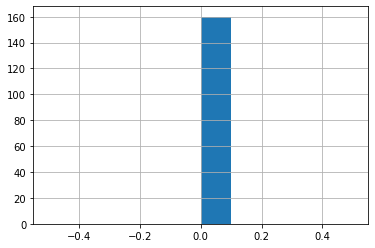

In [413]:
#pd.series(sel.estimator_,feature_importances_,.ravel()).hist()
pd.Series(sel.estimator_.feature_importances_.ravel()).hist()

Subset the account features dataset to include only important vars as determined by RF feature selection

In [414]:
acct_features_train = acct_features_train[selected_feat]
combined_features_train = pd.concat([acct_features_train, text_feature_train], axis=1)

#### Option 2: Lasso RL1 egularization (with Random Forest classification) method for feature selection 

In [130]:
scaler = StandardScaler()
scaler.fit(acct_features_train.fillna(0))

sel_ = SelectFromModel(LogisticRegression(C=1, penalty='l1', solver='liblinear')) # Requires two classes to work of course. 
sel_.fit(scaler.transform(acct_features_train.fillna(0)), labels_train)

ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 1

In [ ]:
selected_feat= acct_features_train.columns[(sel.get_support())]

print('total features: {}'.format((acct_features_train.shape[1])))
print('selected features: {}'.format(len(selected_feat)))
print('features with coefficients shrank to zero: {}'.format(
      np.sum(sel_.estimator_.coef_ == 0)))

In [ ]:
removed_feats = acct_features_train.columns[(sel_.estimator_.coef_ == 0).ravel().tolist()]
removed_feats

Subset account features based on LASSO-selected important features 

In [ ]:
acct_features_train = sel_.transform(acct_features_train.fillna(0))
acct_features_valid = sel_.transform(acct_features_valid.fillna(0))
acct_features_test = sel_.transform(acct_features_test.fillna(0))
acct_features_train.shape, acct_features_valid.shape, acct_features_test.shape

#### Resume after feature selection

Valid

In [415]:
#combined_features_valid = bert_embeddings_df_valid.drop(['suspended'], axis=1)
acct_features_valid = bert_embeddings_df_valid.drop(['suspended'], axis=1).iloc[:,0:bert_embeddings_df_valid.drop(['suspended'], axis=1).columns.get_loc('0')]
text_feature_valid = bert_embeddings_df_valid.iloc[:, bert_embeddings_df_valid.drop(['suspended'], axis=1).columns.get_loc('0') + 1:]
labels_valid = bert_embeddings_df_valid['suspended']

#gets country label number
num_of_labels_valid=labels_valid.nunique()
num_of_labels_valid

2

In [416]:
acct_features_valid = acct_features_valid[selected_feat]
combined_features_valid = pd.concat([acct_features_valid, text_feature_valid], axis=1)

Test

In [417]:
combined_features_test = bert_embeddings_df_test.drop(['suspended'], axis=1)
acct_features_test = bert_embeddings_df_test.drop(['suspended'], axis=1).iloc[:,0:bert_embeddings_df_test.drop(['suspended'], axis=1).columns.get_loc('0')]
text_feature_test = bert_embeddings_df_test.iloc[:, bert_embeddings_df_test.drop(['suspended'], axis=1).columns.get_loc('0') + 1:]
labels_test = bert_embeddings_df_test['suspended']

#gets country label number
num_of_labels_test=labels_test.nunique()
num_of_labels_test

2

In [418]:
acct_features_test = acct_features_test[selected_feat]
combined_features_test = pd.concat([acct_features_test, text_feature_test], axis=1)

#### Label Encoding

In [419]:
#Label encoding (Have not had work yet, but may on full data)
def label_encoding(labels):
    LE = LabelEncoder()
    fit=LE.fit(labels)
    labels =fit.transform(labels)
    labels = to_categorical(labels)
    return labels, fit

In [420]:
#Test label_encoding
labels, fit=label_encoding(labels_train)

#### Calculate class weights to address class imbalance problem. 

In [421]:
mapping = {0:0, 1:1}

def data_prep(dataset):
    y = []
    for i in range(0,len(dataset)):
        y_val = np.zeros(2)
        y_val[mapping[dataset[i]]] = 1
        y.append(y_val)
    return np.array(y)

In [422]:
labels_train_fw = data_prep(labels_train)
len(labels_train_fw)

300

In [423]:
class_counts = [0, 0]
for el in labels_train_fw :
    class_counts[np.argmax(el)]+=1
class_weights = {idx:sum(class_counts)/el for idx, el in enumerate(class_counts)}

ZeroDivisionError: division by zero

#### Text Only Model 

In [424]:
#make sure numpy array
# X
train_data_tweettext = np.array(text_feature_train)
valid_data_tweettext = np.array(text_feature_valid)
test_data_tweettext = np.array(text_feature_test)

# Y
train_labels_tweettext = labels_train
valid_labels_tweettext = labels_valid
test_labels_tweettext = labels_test

In [425]:
#input shape for tweet embeddings
input_shape_tweettext=train_data_tweettext[0].shape
input_shape_tweettext

(768,)

In [426]:
#generate random seed
def random_seeds(seed):
   os.environ['PYTHONHASHSEED']=str(seed)
   tf.random.set_seed(seed)
   np.random.seed(seed)
   rn.seed(seed)

#set seed
random_seeds(1234)

In [427]:
#Function for model flow. Does not include any parameter tuning
def model_flow(model_name, num_countries, input_shape):
    inputs = keras.Input(shape=(input_shape), name="Combined_inputs")
    x = layers.Dense(64, activation="relu", name="dense_1")(inputs)
    x = layers.BatchNormalization(name="normalization_1")(x)
    x = layers.Dense(32, activation="relu",name="dense_2")(x)
    x = layers.Dense(16, activation=tf.keras.layers.LeakyReLU(alpha=0.2), name="dense_3")(x)
    x = layers.Dropout(0.15)(x)
    outputs = layers.Dense(num_of_labels, activation="softmax",name="predictions")(x)
    model = keras.Model(inputs=inputs, outputs=outputs, name=model_name)
    return model

In [428]:
#model flow and summary
Tweettext_model = model_flow("Tweet_text",num_of_labels, input_shape_tweettext)
Tweettext_model.summary()

Model: "Tweet_text"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Combined_inputs (InputLayer) [(None, 768)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                49216     
_________________________________________________________________
normalization_1 (BatchNormal (None, 64)                256       
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
predictions (Dense)          (None, 1)                 1

In [429]:
#Compile  model
Tweettext_model.compile(optimizer='adam',
             loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
             metrics=['accuracy'])

In [430]:
#Fitting on training and validation data
print("Fit model on Tweet Text training data")
history_tweettext = Tweettext_model.fit(train_data_tweettext, train_labels_tweettext, epochs=10, batch_size=15,
                   validation_data=(valid_data_tweettext, valid_labels_tweettext), class_weight = class_weights)

Fit model on Tweet Text training data
Epoch 1/10
20/20 [==============================] - 2s 44ms/step - loss: 0.8570 - accuracy: 1.0000 - val_loss: 0.9413 - val_accuracy: 0.1167
Epoch 2/10
20/20 [==============================] - 0s 4ms/step - loss: 0.2541 - accuracy: 1.0000 - val_loss: 1.3370 - val_accuracy: 0.1167
Epoch 3/10
20/20 [==============================] - 0s 5ms/step - loss: 0.1163 - accuracy: 1.0000 - val_loss: 1.7218 - val_accuracy: 0.1167
Epoch 4/10
20/20 [==============================] - 0s 5ms/step - loss: 0.0563 - accuracy: 1.0000 - val_loss: 2.1117 - val_accuracy: 0.1167
Epoch 5/10
20/20 [==============================] - 0s 5ms/step - loss: 0.0352 - accuracy: 1.0000 - val_loss: 2.4808 - val_accuracy: 0.1167
Epoch 6/10
20/20 [==============================] - 0s 6ms/step - loss: 0.0229 - accuracy: 1.0000 - val_loss: 2.8405 - val_accuracy: 0.1167
Epoch 7/10
20/20 [==============================] - 0s 5ms/step - loss: 0.0144 - accuracy: 1.0000 - val_loss: 3.1593 - va

In [431]:
# Evaluate the model on the test data
print("Evaluate on Tweet Text test data")
Tweettext_model_results = Tweettext_model.evaluate(test_data_tweettext,test_labels_tweettext, batch_size=10)

Evaluate on Tweet Text test data
30/30 [==============================] - 0s 1ms/step - loss: 4.3463 - accuracy: 0.0833


#### Save Model

In [432]:
Tweettext_model.save('Tweettext_model.h5')  # creates a HDF5 file 'my_model.h5'
client = boto3.client('s3')
s3.upload_file(Filename='Tweettext_model.h5',
                  Bucket=import_bucket,
                  Key='modeling/model_output/Tweettext_model.h5')



#### Make Predictions

#### Load back in model 

In [436]:
s3.download_file(import_bucket,
                     'modeling/model_output/Tweettext_model.h5',
                     'Tweettext_model.h5')
# returns a compiled model
# identical to the previous one
Tweettext_model = load_model('Tweettext_model.h5')

For Tweets

In [437]:
# Generate predictions (location probabilities)
def predict_test(model,test_data, test_labels, fit):
    predictions = model.predict(test_data)
    #y_true=np.argmax(test_labels, axis=0) 
    #y_pred=np.argmax(predictions, axis =0)
    #get labels of prediction
    #label_pred=fit.inverse_transform(y_pred)
    #metrics
    report = classification_report(np.array(test_labels), predictions)
    return report # label_pred

In [438]:
#test predict_test
metrics_report_tweettext=predict_test(Tweettext_model,test_data_tweettext,test_labels_tweettext, fit)

# predicted_susp_tweettext
print(metrics_report_tweettext)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       275
           1       0.08      1.00      0.15        25

    accuracy                           0.08       300
   macro avg       0.04      0.50      0.08       300
weighted avg       0.01      0.08      0.01       300



For Accounts

In [439]:
# Generate summed probabilities at the account level 
def predict_account(model, df_mod, df_bert, df_full):
    predictions = model.predict(df_mod)
    df = pd.DataFrame(predictions, columns = ['pred'])
    df_2 = pd.merge(df_bert['user.id'], df, left_index=True, right_index=True)
    df_fm = df_full[['user.screen_name','user.id', 'suspended']].drop_duplicates(subset=['user.screen_name','user.id'])
    df_3 = pd.merge(df_fm, df_2, left_on='user.id', right_on='user.id')
    df_4 = df_3[['user.screen_name', 'suspended','pred']].groupby('user.screen_name').agg(['sum', 'mean'])
    df_4.drop(('suspended', 'sum'), axis = 1, inplace = True)
    df_4.columns = df_4.columns = [' '.join(col).strip() for col in df_4.columns.values]
    df_4.reset_index(level=0, inplace=True)
    df_4.columns = ["user.screen_name","suspended_label", "total_pre_prob","mean_pred_prob"]
    df_4['pred_class'] = np.where(df_4['mean_pred_prob'] > 0.5, 1,0) # Double check to make sure it's .5

    return df_4

In [440]:
train_account_preds_tweettext = predict_account(Tweettext_model, train_data_tweettext, bert_embeddings_df_train, df_train_f)
train_account_preds_tweettext

,user.screen_name,suspended_label,total_pre_prob,mean_pred_prob,pred_class
0,SFAC_TFA_CN,1,300.0,1.0,1


In [443]:
train_account_preds_tweettext.to_csv('s3://joe-exotic-2020/modeling/account_level_results/train_account_preds_tweettext.csv', index=False, encoding = "utf_8_sig")

In [441]:
#report = classification_report(np.array(test_labels), predictions)
report_tr_tweettext = classification_report(np.array(train_account_preds_tweettext['suspended_label']), np.array(train_account_preds_tweettext['pred_class']))
print(report_tr_tweettext)

              precision    recall  f1-score   support

           1       1.00      1.00      1.00         1

    accuracy                           1.00         1
   macro avg       1.00      1.00      1.00         1
weighted avg       1.00      1.00      1.00         1



In [442]:
valid_account_preds_tweettext = predict_account(Tweettext_model, valid_data_tweettext, bert_embeddings_df_valid, df_valid_f)
valid_account_preds_tweettext

,user.screen_name,suspended_label,total_pre_prob,mean_pred_prob,pred_class
0,601xh,0,5.0,1.0,1
1,FangWu07049399,1,35.0,1.0,1
2,JanierLacy,0,9.0,1.0,1
3,JunaidK83080565,0,3.0,1.0,1
4,MWaseem25724792,0,1.0,1.0,1
5,NJ8f7eaXxguK5os,0,2.0,1.0,1
6,PremchandraWah1,0,2.0,1.0,1
7,SyedkhalilAhma8,0,17.0,1.0,1
8,ZNZCgi4aoxfGq8B,0,1.0,1.0,1
9,ZhuaHei,0,35.0,1.0,1


In [444]:
valid_account_preds_tweettext.to_csv('s3://joe-exotic-2020/modeling/account_level_results/valid_account_preds_tweettext.csv', index=False, encoding = "utf_8_sig")

In [226]:
#report = classification_report(np.array(test_labels), predictions)
report_v_tweettext = classification_report(np.array(valid_account_preds_tweettext['suspended_label']), np.array(valid_account_preds_tweettext['pred_class']))
print(report_v_tweettext)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        14
           1       0.07      1.00      0.12         1

    accuracy                           0.07        15
   macro avg       0.03      0.50      0.06        15
weighted avg       0.00      0.07      0.01        15



In [446]:
test_account_preds_tweettext = predict_account(Tweettext_model, test_data_tweettext, bert_embeddings_df_test, df_test_f)
test_account_preds_tweettext

,user.screen_name,suspended_label,total_pre_prob,mean_pred_prob,pred_class
0,CareerFinal,0,1.0,1.0,1
1,JatoiAhmedraza,0,1.0,1.0,1
2,LUmxrzziJbpT3q8,0,10.0,1.0,1
3,MMunir50647063,0,1.0,1.0,1
4,Mok7dvCtbbp82cm,1,25.0,1.0,1
5,Nikihoo1,0,7.0,1.0,1
6,STX2437,0,57.0,1.0,1
7,haoliyaya,0,12.0,1.0,1
8,ngla_s,0,186.0,1.0,1


In [447]:
test_account_preds_tweettext.to_csv('s3://joe-exotic-2020/modeling/account_level_results/test_account_preds_tweettext.csv', index=False, encoding = "utf_8_sig")

In [228]:
#report = classification_report(np.array(test_labels), predictions)
report_te_tweettext = classification_report(np.array(test_account_preds_tweettext['suspended_label']), np.array(test_account_preds_tweettext['pred_class']))
print(report_te_tweettext)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.11      1.00      0.20         1

    accuracy                           0.11         9
   macro avg       0.06      0.50      0.10         9
weighted avg       0.01      0.11      0.02         9



Tweet Text Model Results

In [230]:
def accuracy_plot(title_, history_fit):
    plt.plot(history_fit.history['accuracy'])
    plt.plot(history_fit.history['val_accuracy'])
    plt.title(title_)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='lower right')
    plt.show()
    return plt

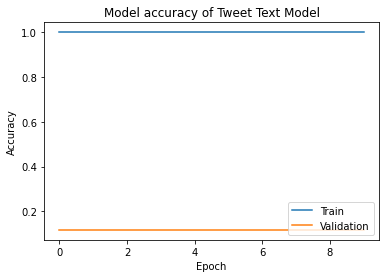

<module 'matplotlib.pyplot' from '/opt/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>
test loss, test accuracy: [4.346324920654297, 0.0833333358168602]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       275
           1       0.08      1.00      0.15        25

    accuracy                           0.08       300
   macro avg       0.04      0.50      0.08       300
weighted avg       0.01      0.08      0.01       300



In [231]:
#train vs validation accuracy plot
plot_tweettext=accuracy_plot('Model accuracy of Tweet Text Model', history_tweettext)
print(plot_tweettext)

#test accuracy
print("test loss, test accuracy:", Tweettext_model_results)
#Countries labels predicted
#print(predicted_countries_tweettext)
#Classification report
print(metrics_report_tweettext)

#### Account only model  

In [232]:
#make sure numpy array
train_data_acc = np.array(acct_features_train).astype(np.float32)
valid_data_acc = np.array(acct_features_valid).astype(np.float32)
test_data_acc = np.array(acct_features_test).astype(np.float32)

train_labels = labels_train
valid_labels = labels_valid
test_labels = labels_test

In [233]:
#input shape for account features
input_shape_acc=train_data_acc[0].shape
input_shape_acc

(162,)

In [234]:
#Function for model flow. Does not include any parameter tuning
def model_flow(model_name, num_countries, input_shape):
    inputs = keras.Input(shape=(input_shape), name="Combined_inputs")
    x = layers.Dense(64, activation="relu", name="dense_1")(inputs)
    x = layers.BatchNormalization(name="normalization_1")(x)
    x = layers.Dense(32, activation="relu",name="dense_2")(x)
    x = layers.Dense(16, activation=tf.keras.layers.LeakyReLU(alpha=0.2), name="dense_3")(x)
    x = layers.Dropout(0.15)(x)
    outputs = layers.Dense(num_of_labels, activation="softmax",name="predictions")(x)
    model = keras.Model(inputs=inputs, outputs=outputs, name=model_name)
    return model

In [235]:
#model flow and summary
Acc_model = model_flow("Account_Info",num_of_labels, input_shape_acc)
Acc_model.summary()

Model: "Account_Info"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Combined_inputs (InputLayer) [(None, 162)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                10432     
_________________________________________________________________
normalization_1 (BatchNormal (None, 64)                256       
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
predictions (Dense)          (None, 1)                

In [236]:
#Compile  model
Acc_model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [239]:
#Fitting on training and validation data
print("Fit model on Account Information features training data")
history_acc = Acc_model.fit(train_data_acc, train_labels, epochs=10, batch_size=15,
                   validation_data=(valid_data_acc, valid_labels), class_weight=class_weights)

Fit model on Account Information features training data
Epoch 1/10
20/20 [==============================] - 1s 17ms/step - loss: 0.4838 - accuracy: 1.0000 - val_loss: nan - val_accuracy: 0.2733
Epoch 2/10
20/20 [==============================] - 0s 5ms/step - loss: 0.1780 - accuracy: 1.0000 - val_loss: nan - val_accuracy: 0.2733
Epoch 3/10
20/20 [==============================] - 0s 5ms/step - loss: 0.0620 - accuracy: 1.0000 - val_loss: nan - val_accuracy: 0.2733
Epoch 4/10
20/20 [==============================] - 0s 6ms/step - loss: 0.0272 - accuracy: 1.0000 - val_loss: nan - val_accuracy: 0.2733
Epoch 5/10
20/20 [==============================] - 0s 5ms/step - loss: 0.0189 - accuracy: 1.0000 - val_loss: nan - val_accuracy: 0.2733
Epoch 6/10
20/20 [==============================] - 0s 6ms/step - loss: 0.0110 - accuracy: 1.0000 - val_loss: nan - val_accuracy: 0.2733
Epoch 7/10
20/20 [==============================] - 0s 5ms/step - loss: 0.0055 - accuracy: 1.0000 - val_loss: nan - val_a

In [240]:
# Evaluate the model on the test data
print("Evaluate on Account Information features test data")
Acc_model_results = Acc_model.evaluate(test_data_acc, test_labels, batch_size=10)

Evaluate on Account Information features test data
30/30 [==============================] - 0s 895us/step - loss: nan - accuracy: 0.1933


#### Save Model 

In [ ]:
Acc_model.save('Acc_model.h5')  # creates a HDF5 file 'my_model.h5'
s3.upload_file(Filename='Acc_model.h5',
                  Bucket=import_bucket,
                  Key='modeling/model_output/Acc_model.h5')



#### Load back in model 

In [ ]:
s3.download_file(import_bucket,
                     'modeling/model_output/Acc_model.h5',
                     'Acc_model.h5')
# returns a compiled model
# identical to the previous one
Acc_model = load_model('Acc_model.h5')

#### Make Predictions

For Tweets

In [ ]:
#test predict_test
metrics_report_acc=predict_test(Acc_model,test_data_acc,test_labels, fit)

# predicted_susp_tweettext
print(metrics_report_acc)


For Accounts

In [253]:
train_account_preds_acc = predict_account(Acc_model, train_data_acc, bert_embeddings_df_train, df_train_f)
train_account_preds_acc

,user.screen_name,suspended_label,total_pre_prob,mean_pred_prob,pred_class
0,SFAC_TFA_CN,1,300.0,1.0,1


In [ ]:
train_account_preds_acc.to_csv('s3://joe-exotic-2020/modeling/account_level_results/train_account_preds_acc.csv', index=False, encoding = "utf_8_sig")

In [254]:
#report = classification_report(np.array(test_labels), predictions)
report_tr_acc = classification_report(np.array(train_account_preds_acc['suspended_label']), np.array(train_account_preds_acc['pred_class']))
print(report_tr_acc)

              precision    recall  f1-score   support

           1       1.00      1.00      1.00         1

    accuracy                           1.00         1
   macro avg       1.00      1.00      1.00         1
weighted avg       1.00      1.00      1.00         1



In [255]:
valid_account_preds_acc = predict_account(Acc_model, valid_data_acc, bert_embeddings_df_valid, df_valid_f)
valid_account_preds_acc

,user.screen_name,suspended_label,total_pre_prob,mean_pred_prob,pred_class
0,601xh,0,5.0,1.0,1
1,FangWu07049399,1,34.0,1.0,1
2,JanierLacy,0,0.0,NaN,0
3,JunaidK83080565,0,1.0,1.0,1
4,MWaseem25724792,0,0.0,NaN,0
5,NJ8f7eaXxguK5os,0,1.0,1.0,1
6,PremchandraWah1,0,0.0,NaN,0
7,SyedkhalilAhma8,0,11.0,1.0,1
8,ZNZCgi4aoxfGq8B,0,0.0,NaN,0
9,ZhuaHei,0,30.0,1.0,1


In [ ]:
valid_account_preds_acc.to_csv('s3://joe-exotic-2020/modeling/account_level_results/valid_account_preds_acc.csv', index=False, encoding = "utf_8_sig")

In [256]:
#report = classification_report(np.array(test_labels), predictions)
report_v_acc = classification_report(np.array(valid_account_preds_acc['suspended_label']), np.array(valid_account_preds_acc['pred_class']))
print(report_v_acc)

              precision    recall  f1-score   support

           0       1.00      0.36      0.53        14
           1       0.10      1.00      0.18         1

    accuracy                           0.40        15
   macro avg       0.55      0.68      0.35        15
weighted avg       0.94      0.40      0.50        15



In [257]:
test_account_preds_acc = predict_account(Acc_model, test_data_acc, bert_embeddings_df_test, df_test_f)
test_account_preds_acc

,user.screen_name,suspended_label,total_pre_prob,mean_pred_prob,pred_class
0,CareerFinal,0,0.0,NaN,0
1,JatoiAhmedraza,0,0.0,NaN,0
2,LUmxrzziJbpT3q8,0,8.0,1.0,1
3,MMunir50647063,0,0.0,NaN,0
4,Mok7dvCtbbp82cm,1,22.0,1.0,1
5,Nikihoo1,0,5.0,1.0,1
6,STX2437,0,43.0,1.0,1
7,haoliyaya,0,11.0,1.0,1
8,ngla_s,0,172.0,1.0,1


In [ ]:
test_account_preds_acc.to_csv('s3://joe-exotic-2020/modeling/account_level_results/test_account_preds_acc.csv', index=False, encoding = "utf_8_sig")

In [258]:
#report = classification_report(np.array(test_labels), predictions)
report_te_acc = classification_report(np.array(test_account_preds_acc['suspended_label']), np.array(test_account_preds_acc['pred_class']))
print(report_te_acc)

              precision    recall  f1-score   support

           0       1.00      0.38      0.55         8
           1       0.17      1.00      0.29         1

    accuracy                           0.44         9
   macro avg       0.58      0.69      0.42         9
weighted avg       0.91      0.44      0.52         9



Account Information Model Results

In [ ]:
#train vs validation accuracy plot
plot_acc=accuracy_plot('Model accuracy of Account Information Features Model', history_acc)
print(plot_acc)

#train vs validation accuracy plot
print(plot_acc)
#test accuracy
print("test loss, test accuracy:", Acc_model_results)
#Countries labels predicted
#print(predicted_countries_acc)
#Classification report
print(metrics_report_acc)

#### Combined Model

In [532]:
#make sure numpy array
train_data = np.array(combined_features_train).astype(np.float32)
valid_data = np.array(combined_features_valid).astype(np.float32)
test_data = np.array(combined_features_test).astype(np.float32)

train_labels = labels_train
valid_labels = labels_valid
test_labels = labels_test

In [533]:
#gets shape of the data for the model
input_shape_combined=valid_data[0].shape
input_shape_combined

(928,)

In [534]:
valid_data[0].shape

(928,)

In [535]:
#set seed
random_seeds(1234)

In [536]:
#test model_flow
Combined_model = model_flow("Combined",11, input_shape_combined)

In [537]:
#model summary
Combined_model.summary()


Model: "Combined"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Combined_inputs (InputLayer) [(None, 928)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                59456     
_________________________________________________________________
normalization_1 (BatchNormal (None, 64)                256       
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_5 (Dropout)          (None, 16)                0         
_________________________________________________________________
predictions (Dense)          (None, 1)                 17 

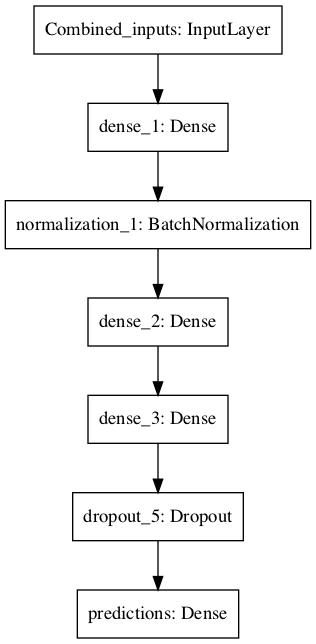

In [538]:
#model diagram
tf.keras.utils.plot_model(Combined_model)

In [539]:
#Compile  model
Combined_model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [541]:
#Fitting on training and validation data
print("Fit model on training data")
history_combined = Combined_model.fit(train_data, train_labels, epochs=10, batch_size=15,
                                      validation_data=(valid_data, valid_labels), class_weight = class_weights)

Fit model on training data
Epoch 1/10
1/1 [==============================] - 0s 305ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 1.0000
Epoch 2/10
1/1 [==============================] - 0s 51ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 1.0000
Epoch 3/10
1/1 [==============================] - 0s 46ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 1.0000
Epoch 4/10
1/1 [==============================] - 0s 55ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 1.0000
Epoch 5/10
1/1 [==============================] - 0s 47ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 1.0000
Epoch 6/10
1/1 [==============================] - 0s 56ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 1.0000
Epoch 7/10
1/1 [==============================] - 0s 48ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 1.0000
Epoch 8/10
1/

In [ ]:
# model.save("/prediction.h5")

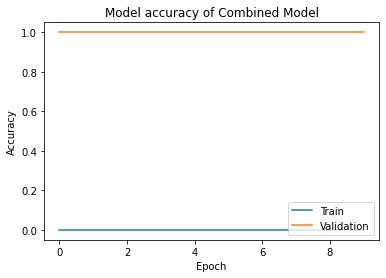

In [543]:
#test accuracy_plot
plot_combined=accuracy_plot('Model accuracy of Combined Model', history_combined)

In [544]:
# Evaluate the model on the test data
print("Evaluate on test data")
model_results_comb = Combined_model.evaluate(test_data, test_labels, batch_size=10)

Evaluate on test data
1/1 [==============================] - 0s 145ms/step - loss: nan - accuracy: 1.0000


#### Save Model 

In [ ]:
Acc_model.save('Combined_model.h5')  # creates a HDF5 file 'my_model.h5'
s3.upload_file(Filename='Combined_model.h5',
                  Bucket=import_bucket,
                  Key='modeling/model_output/Combined_model.h5')



#### Load Model 

In [ ]:
s3.download_file(import_bucket,
                     'modeling/model_output/Combined_model.h5',
                     'Combined_model.h5')
# returns a compiled model
# identical to the previous one
Combined_model = load_model('Combined_model.h5')

#### Predictions

Tweets

In [ ]:
#test predict_test
metrics_report_comb=predict_test(Combined_model,test_data,test_labels, fit)

# predicted_susp_tweettext
print(metrics_report_comb)

Accounts

In [ ]:
train_account_preds_comb = predict_account(Combined_model, train_data, bert_embeddings_df_train, df_train_f)
train_account_preds_comb

In [ ]:
train_account_preds_comb.to_csv('s3://joe-exotic-2020/modeling/account_level_results/train_account_preds_comb.csv', index=False, encoding = "utf_8_sig")

In [ ]:
#report = classification_report(np.array(test_labels), predictions)
report_tr_comb = classification_report(np.array(train_account_preds_comb['suspended_label']), np.array(train_account_preds_comb['pred_class']))
print(report_tr_comb)

In [ ]:
valid_account_preds_comb = predict_account(Combined_model, valid_data, bert_embeddings_df_valid, df_valid_f)
valid_account_preds_comb

In [ ]:
valid_account_preds_comb.to_csv('s3://joe-exotic-2020/modeling/account_level_results/valid_account_preds_comb.csv', index=False, encoding = "utf_8_sig")


In [ ]:
#report = classification_report(np.array(test_labels), predictions)
report_v_comb = classification_report(np.array(valid_account_preds_comb['suspended_label']), np.array(valid_account_preds_comb['pred_class']))
print(report_v_comb)

In [ ]:
test_account_preds_comb = predict_account(Combined_model, test_data, bert_embeddings_df_test, df_test_f)
test_account_preds_comb

In [ ]:
test_account_preds_comb.to_csv('s3://joe-exotic-2020/modeling/account_level_results/test_account_preds_comb.csv', index=False, encoding = "utf_8_sig")



In [ ]:
#report = classification_report(np.array(test_labels), predictions)
report_te_comb = classification_report(np.array(test_account_preds_comb['suspended_label']), np.array(test_account_preds_comb['pred_class']))
print(report_te_comb)

In [ ]:
#train vs validation accuracy plot
plot_combined=accuracy_plot('Model accuracy of Combined Model', history_combined)
print(plot_combined)

#train vs validation accuracy plot
print(plot_combined)
#test accuracy
print("test loss, test accuracy:", model_results_comb)
#Countries labels predicted
#print(predicted_countries)
#Classification report
print(metrics_report_comb)

### 3. Fine Tuning Models

#### Text Only Model 

In [591]:
input_shape_tweettext=train_data_tweettext[0].shape
input_shape_tweettext


(768,)

In [592]:
def tuner_builder(hp):
    inputs = keras.Input(input_shape_tweettext, name="Tuned_Tweet_Text_Inputs")
    x = layers.Dense(hp.Int('units', 50, 200, step = 20), activation="relu", name="dense_1")(inputs)
    x = layers.BatchNormalization(name="normalization_1")(x)
    x = layers.Dense(hp.Int('units1', 100, 200, step = 50), activation="relu",name="dense_2")(x)
    x = layers.Dense(hp.Int('units2', 20, 100, step = 20), activation=tf.keras.layers.LeakyReLU(alpha=0.2), name="dense_3")(x)
    x = layers.Dropout(hp.Float('dropout',0.0,0.50, step=0.10, default=0.10))(x)
    outputs = layers.Dense(2, activation="softmax",name="predictions")(x)
    model = keras.Model(inputs=inputs, outputs=outputs, name="Tuned_Tweet_Text_Model")
    #Compile  model
    model.compile(optimizer=tf.keras.optimizers.Adam(
      hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')),
      loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
      metrics=['accuracy'])
    return model

In [593]:
#tuner settings 
TweetText_tuner = kt.Hyperband(
    tuner_builder,
    objective='val_accuracy',
    max_epochs=50,
    factor=3,
    directory = 'Trial_run_tweettext',
    project_name = 'Parameters_trials_tweettext')

In [ ]:
#run through tuner
TweetText_tuner.search(train_data_tweettext, train_labels_tweettext,validation_data=(valid_data_tweettext, valid_labels_tweettext),
             callbacks=[callback1,ClearTrainingOutput()])

In [ ]:
#gets best parameters
best_hyper_TweetText = TweetText_tuner.get_best_hyperparameters(1)[0]
best_hyper_TweetText

In [ ]:
print('Best Parameters for 1st Dense layer is', best_hyper_TweetText.get('units'))

In [ ]:
print('Best Parameters for 2nd Dense layer is', best_hyper_TweetText.get('units1'))

In [ ]:
print('Best Parameters for 3rd Dense layer is', best_hyper_TweetText.get('units2'))

In [ ]:
print('Best Parameters for Dropout layer is', best_hyper_TweetText.get('dropout'))

In [ ]:
print('Best learning rate for the ADAM is', best_hyper_TweetText.get('learning_rate'))

In [ ]:
#applies to tuning to model
TweetText_model_tuned= TweetText_tuner.hypermodel.build(best_hyper_TweetText)

In [ ]:
#Fitting on training and validation data
print("Fit model on Tuned Tweet Text training data")
history_tweettext_tuned = TweetText_model_tuned.fit(train_data_tweettext, train_labels_tweettext, epochs=10, batch_size=15,
                   validation_data=(valid_data_tweettext, valid_labels_tweettext), class_weight = class_weights)

In [ ]:
plot_tweettext_tuned=accuracy_plot('Model accuracy of Tuned Tweet Text Model', history_tweettext_tuned)

In [ ]:
# Evaluate the model on the test data
print("Evaluate on Tuned Tweet Text test data")
Tweettext_model_tuned_results = TweetText_model_tuned.evaluate(test_data_tweettext,test_labels_tweettext, batch_size=10)

#### Save Model 

In [ ]:
TweetText_model_tuned.save('TweetText_model_tuned.h5')  # creates a HDF5 file 'my_model.h5'
s3.upload_file(Filename='TweetText_model_tuned.h5',
                  Bucket=import_bucket,
                  Key='modeling/model_output/TweetText_model_tuned.h5')

#### Load Model 

In [ ]:
s3.download_file(import_bucket,
                     'modeling/model_output/TweetText_model_tuned.h5',
                     'TweetText_model_tuned.h5')
# returns a compiled model
# identical to the previous one
TweetText_model_tuned = load_model('TweetText_model_tuned.h5')



Predict

In [ ]:
#test predict_test
metrics_report_tweettext_tuned=predict_test(TweetText_model_tuned,test_data_tweettext,test_labels_tweettext, fit)

# predicted_susp_tweettext
print(metrics_report_tweettext_tuned)

In [ ]:
train_account_preds_tweettext_tuned = predict_account(TweetText_model_tuned, train_data_tweettext, bert_embeddings_df_train, df_train_f)
train_account_preds_tweettext_tuned

In [ ]:
train_account_preds_tweettext_tuned.to_csv('s3://joe-exotic-2020/modeling/account_level_results/train_account_preds_tweettext_tuned.csv', index=False, encoding = "utf_8_sig")

In [ ]:
#report = classification_report(np.array(test_labels), predictions)
report_tr_tweettext_tuned = classification_report(np.array(train_account_preds_tweettext_tuned['suspended_label']), np.array(train_account_preds_tweettext_tuned['pred_class']))
print(report_tr_tweettext_tuned)

In [ ]:
valid_account_preds_tweettext_tuned = predict_account(TweetText_model_tuned, valid_data_tweettext, bert_embeddings_df_valid, df_valid_f)
valid_account_preds_tweettext_tuned

In [ ]:
valid_account_preds_tweettext_tuned.to_csv('s3://joe-exotic-2020/modeling/account_level_results/valid_account_preds_tweettext_tuned.csv', index=False, encoding = "utf_8_sig")

In [ ]:
#report = classification_report(np.array(test_labels), predictions)
report_v_tweettext_tuned = classification_report(np.array(valid_account_preds_tweettext_tuned['suspended_label']), np.array(valid_account_preds_tweettext_tuned['pred_class']))
print(report_v_tweettext_tuned)

In [ ]:
test_account_preds_tweettext_tuned = predict_account(TweetText_model_tuned, test_data_tweettext, bert_embeddings_df_test, df_test_f)
test_account_preds_tweettext_tuned

In [ ]:
test_account_preds_tweettext_tuned.to_csv('s3://joe-exotic-2020/modeling/account_level_results/test_account_preds_tweettext_tuned.csv', index=False, encoding = "utf_8_sig")

In [ ]:
#report = classification_report(np.array(test_labels), predictions)
report_te_tweettext_tuned = classification_report(np.array(test_account_preds_tweettext_tuned['suspended_label']), np.array(test_account_preds_tweettext_tuned['pred_class']))
print(report_te_tweettext_tuned)

Tweet Text Model with Fine Tuning Results

In [ ]:
#train vs validation accuracy plot
print(plot_tweettext_tuned)
#test accuracy
print("test loss, test accuracy:", Tweettext_model_tuned_results)
#Countries labels predicted
#print(predicted_countries_tweettext_tuned)
#Classification report
print(metrics_report_tweettext_tuned)

#### Account Only Model 

In [589]:
#input shape for account features
input_shape_acc=train_data_acc[0].shape
input_shape_acc

(160,)

In [590]:
def tuner_builder1(hp):
    inputs = keras.Input(shape=input_shape_acc, name="Tuned_Account_Info_Inputs")
    x = layers.Dense(hp.Int('units', 50, 200, step = 20), activation="relu", name="dense_1")(inputs)
    x = layers.BatchNormalization(name="normalization_1")(x)
    x = layers.Dense(hp.Int('units1', 100, 200, step = 50), activation="relu",name="dense_2")(x)
    x = layers.Dense(hp.Int('units2', 20, 100, step = 20), activation=tf.keras.layers.LeakyReLU(alpha=0.2), name="dense_3")(x)
    x = layers.Dropout(hp.Float('dropout',0.0,0.50, step=0.10, default=0.10))(x)
    outputs = layers.Dense(2, activation="softmax",name="predictions")(x)
    model = keras.Model(inputs=inputs, outputs=outputs, name="Tuned_Account_Info_Model")
    #Compile  model
    model.compile(optimizer=tf.keras.optimizers.Adam(
        hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')),
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
        metrics=['accuracy'])
    return model

In [ ]:
#tuner settings 
Acc_info_tuner = kt.Hyperband(
    tuner_builder1,
    objective='val_accuracy',
    max_epochs=50,
    factor=3,
    directory = 'Trial_run_acc_info2',
    project_name = 'Parameters_trials_acc_info2')

In [ ]:
#run through tuner
Acc_info_tuner.search(train_data_acc, train_labels_acc,validation_data=(valid_data_acc, valid_labels_acc),callbacks=[callback1,ClearTrainingOutput()])


In [ ]:
#gets best parameters
best_hyper_Acc_info = Acc_info_tuner.get_best_hyperparameters(1)[0]
best_hyper_Acc_info
    

In [ ]:
print('Best Parameters for 1st Dense layer is', best_hyper_Acc_info.get('units'))

In [ ]:
print('Best Parameters for 2nd Dense layer is', best_hyper_Acc_info.get('units1'))

In [ ]:
print('Best Parameters for 3rd Dense layer is', best_hyper_Acc_info.get('units2'))

In [ ]:
print('Best Parameters for Dropout layer is', best_hyper_Acc_info.get('dropout'))

In [ ]:
print('Best learning rate for the ADAM is', best_hyper_Acc_info.get('learning_rate'))

In [ ]:
#applies to tuning to model
Acc_info_model_tuned= Acc_info_tuner.hypermodel.build(best_hyper_Acc_info)

In [ ]:
#trials using newly tuned model
#Fitting on training and validation data based on selected tuning parameters
print("Fit model on training data with tuned Account Information model")
history_acc_info_tuned = Acc_info_model_tuned.fit(train_data_acc, train_labels_acc, epochs=10, batch_size=15,
                   validation_data=(valid_data_acc, valid_labels_acc), class_weight = class_weights)

In [ ]:
plot_acc_info_tuned=accuracy_plot('Model accuracy of Tuned Account Information Model', history_acc_info_tuned)

In [ ]:
# Evaluate the tuned model on the test data 
print("Evaluate tuned Account Information model on test data")
acc_info_tuned_results = Acc_info_model_tuned.evaluate(test_data_acc, test_labels_acc, batch_size=10)

#### Save Model 

In [ ]:
Acc_info_model_tuned.save('Acc_info_model_tuned.h5')  # creates a HDF5 file 'my_model.h5'
s3.upload_file(Filename='Acc_info_model_tuned.h5',
                  Bucket=import_bucket,
                  Key='modeling/model_output/Acc_info_model_tuned.h5')



#### Load Model 

In [ ]:
s3.download_file(import_bucket,
                     'modeling/model_output/Acc_info_model_tuned.h5',
                     'Acc_info_model_tuned.h5')
# returns a compiled model
# identical to the previous one
Tweettext_model = load_model('Acc_info_model_tuned.h5')

#### Predict 

Tweets

In [ ]:
#test predict_test
metrics_report_acc_tuned=predict_test(Acc_info_model_tuned,test_data_acc,test_labels, fit)

# predicted_susp_tweettext
print(metrics_report_acc_tuned)

Accounts

In [ ]:
train_account_preds_acc_tuned = predict_account(Acc_info_model_tuned, train_data_acc, bert_embeddings_df_train, df_train_f)
train_account_preds_acc_tuned

In [ ]:
train_account_preds_acc_tuned.to_csv('s3://joe-exotic-2020/modeling/account_level_results/train_account_preds_acc_tuned.csv', index=False, encoding = "utf_8_sig")

In [ ]:
#report = classification_report(np.array(test_labels), predictions)
report_tr_acc_tuned = classification_report(np.array(train_account_preds_acc_tuned['suspended_label']), np.array(train_account_preds_acc_tuned['pred_class']))
print(report_tr_acc_tuned)


In [ ]:
valid_account_preds_acc_tuned = predict_account(Acc_info_model_tuned, valid_data_acc, bert_embeddings_df_valid, df_valid_f)
valid_account_preds_acc_tuned

In [ ]:
valid_account_preds_acc_tuned.to_csv('s3://joe-exotic-2020/modeling/account_level_results/valid_account_preds_acc_tuned.csv', index=False, encoding = "utf_8_sig")

In [ ]:
#report = classification_report(np.array(test_labels), predictions)
report_v_acc_tuned = classification_report(np.array(valid_account_preds_acc_tuned['suspended_label']), np.array(valid_account_preds_acc_tuned['pred_class']))
print(report_v_acc_tuned)

In [ ]:
test_account_preds_acc_tuned = predict_account(Acc_info_model_tuned, test_data_acc, bert_embeddings_df_test, df_test_f)
test_account_preds_acc_tuned

In [ ]:
test_account_preds_acc_tuned.to_csv('s3://joe-exotic-2020/modeling/account_level_results/test_account_preds_acc_tuned.csv', index=False, encoding = "utf_8_sig")


In [ ]:
#report = classification_report(np.array(test_labels), predictions)
report_te_acc_tuned_tuned = classification_report(np.array(test_account_preds_acc_tuned['suspended_label']), np.array(test_account_preds_acc_tuned['pred_class']))
print(report_te_acc)

Account Information Model with Fine Tuning Results

In [ ]:
#train vs validation accuracy plot
print(plot_acc_info_tuned)
#test accuracy
print("test loss, test accuracy:", acc_info_tuned_results)
#Countries labels predicted
#print(predicted_countries_acc_info_tuned)
#Classification report
print(metrics_report_acc_info_tuned)

#### Combined Model

In [582]:
#gets shape of the data for the model
input_shape_combined=train_data[0].shape
input_shape_combined

(928,)

In [583]:
#Function to tune to the model
def tuner_builder(hp):
    inputs = keras.Input(shape=input_shape_combined, name="Tuned_Combined_Inputs") # They had 3333 (w CV) -> I hard coded my model shape. 
    x = layers.Dense(hp.Int('units', 50, 200, step = 20), activation="relu", name="dense_1")(inputs)
    x = layers.BatchNormalization(name="normalization_1")(x)
    x = layers.Dense(hp.Int('units1', 100, 200, step = 50), activation="relu",name="dense_2")(x)
    x = layers.Dense(hp.Int('units2', 20, 100, step = 20), activation=tf.keras.layers.LeakyReLU(alpha=0.2), name="dense_3")(x)
    x = layers.Dropout(hp.Float('dropout',0.0,0.50, step=0.10, default=0.10))(x)
    outputs = layers.Dense(2, activation="softmax",name="predictions")(x) # I get error now, but with full data there will be 2
    model = keras.Model(inputs=inputs, outputs=outputs, name="Tuned_Combined_Model")
    #Compile  model
    model.compile(optimizer=tf.keras.optimizers.Adam(
        hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')),
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    return model

In [584]:
#tuner settings 
Combined_tuner = kt.Hyperband(
    tuner_builder,
    objective='val_accuracy',
    max_epochs=50,
    factor=3,
    directory = 'Trial_run_combined2',
    project_name = 'Parameters_trials_combined2')

INFO:tensorflow:Reloading Oracle from existing project Trial_run_combined2/Parameters_trials_combined2/oracle.json


In [585]:
#Callbacks
callback1=tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=4)

In [586]:
#clears training output
class ClearTrainingOutput(tf.keras.callbacks.Callback):
    def on_train_end(*args, **kwargs):
        IPython.display.clear_output(wait = True)

In [ ]:
#run through tuner
Combined_tuner.search(train_data, train_labels,validation_data=(valid_data, valid_labels),
             callbacks=[callback1,ClearTrainingOutput()])

In [ ]:
#gets best parameters
best_hyper_combined = Combined_tuner.get_best_hyperparameters(1)[0]
best_hyper_combined

In [ ]:
print('Best Parameters for 1st Dense layer is', best_hyper_combined.get('units'))

In [ ]:
print('Best Parameters for 2nd Dense layer is', best_hyper_combined.get('units1'))

In [ ]:
print('Best Parameters for 3rd Dense layer is', best_hyper_combined.get('units2'))

In [ ]:
print('Best Parameters for Dropout layer is', best_hyper_combined.get('dropout'))

In [ ]:
print('Best learning rate for the ADAM is', best_hyper_combined.get('learning_rate'))

In [ ]:
#applies to tuning to model
Combined_model_tuned= Combined_tuner.hypermodel.build(best_hyper_combined)

In [ ]:
#trials using newly tuned model
#Fitting on training and validation data based on selected tuning parameters
print("Fit model on training data with tuned model")
history_combined_tuned = Combined_model_tuned.fit(train_data, train_labels, epochs=10, batch_size=15,
                   validation_data=(valid_data, valid_labels), class_weight = class_weights)

In [ ]:
plot_combined_tuned=accuracy_plot('Model accuracy of Tuned Combined Model', history_combined_tuned)

In [ ]:
# Evaluate the tuned model on the test data 
print("Evaluate tuned model on test data")
Combined_model_tuned_results = Combined_model_tuned.evaluate(test_data, test_labels, batch_size=10)

#### Save Model 

In [ ]:
Acc_model.save('Combined_model_tuned.h5')  # creates a HDF5 file 'my_model.h5'
s3.upload_file(Filename='Combined_model_tuned.h5',
                  Bucket=import_bucket,
                  Key='modeling/model_output/Combined_model_tuned.h5')

#### Import Model 

In [ ]:
s3.download_file(import_bucket,
                     'modeling/model_output/Combined_model_tuned.h5',
                     'Combined_model_tuned.h5')
# returns a compiled model
# identical to the previous one
Tweettext_model = load_model('Combined_model_tuned.h5')

#### Predict

Tweets

In [ ]:
#test predict_test
metrics_report_comb_tuned=predict_test(Combined_model,test_data,test_labels, fit)

# predicted_susp_tweettext
print(metrics_report_comb_tuned)

Accounts

In [ ]:
train_account_preds_comb_tuned = predict_account(Combined_model_tuned, train_data, bert_embeddings_df_train, df_train_f)
train_account_preds_comb_tuned

In [ ]:
train_account_preds_comb_tuned.to_csv('s3://joe-exotic-2020/modeling/account_level_results/train_account_preds_comb_tuned.csv', index=False, encoding = "utf_8_sig")


In [ ]:
#report = classification_report(np.array(test_labels), predictions)
report_tr_comb_tuned = classification_report(np.array(train_account_preds_comb_tuned['suspended_label']), np.array(train_account_preds_comb_tuned['pred_class']))
print(report_tr_comb_tuned)

In [ ]:
valid_account_preds_comb_tuned = predict_account(Combined_model_tuned, valid_data, bert_embeddings_df_valid, df_valid_f)
valid_account_preds_comb_tuned

In [ ]:
valid_account_preds_comb_tuned.to_csv('s3://joe-exotic-2020/modeling/account_level_results/valid_account_preds_comb_tuned.csv', index=False, encoding = "utf_8_sig")

In [ ]:
#report = classification_report(np.array(test_labels), predictions)
report_v_comb_tuned = classification_report(np.array(valid_account_preds_comb_tuned['suspended_label']), np.array(valid_account_preds_comb_tuned['pred_class']))
print(report_v_comb_tuned)

In [ ]:
test_account_preds_comb_tuned = predict_account(Combined_model_tuned, test_data, bert_embeddings_df_test, df_test_f)
test_account_preds_comb_tuned

In [ ]:
test_account_preds_comb_tuned.to_csv('s3://joe-exotic-2020/modeling/account_level_results/test_account_preds_comb_tuned.csv', index=False, encoding = "utf_8_sig")


In [ ]:
#report = classification_report(np.array(test_labels), predictions)
report_te_comb = classification_report(np.array(test_account_preds_comb_tuned['suspended_label']), np.array(test_account_preds_comb_tuned['pred_class']))
print(report_te_comb_tuned)

Combined Model with Fine Tuning Results

In [ ]:
#train vs validation accuracy plot
print(plot_combined_tuned)
#test accuracy
print("test loss, test accuracy:", Combined_model_tuned_results)
#Countries labels predicted
#print(predicted_countries_tuned)
#Classification report
print(metrics_report_comb_tuned)